在这个项目中，将分析一项 A/B 测试的结果：游戏首次出现的关卡从第30关移至第40关。具体将分析这一改动对玩家留存率和游戏轮次的影响。

数据来源是参与测试期间安装游戏的 90,189 名玩家。包含的变量有：

- userid：唯一标识玩家的编号
- version：玩家所属组别（控制组 gate_30 或测试组 gate_40）
- sum_gamerounds：玩家安装后首周的游戏总轮次
- retention_1：玩家是否在安装1天后返回游戏
- retention_7：玩家是否在安装7天后返回游戏
玩家在安装游戏时会被随机分配到 gate_30（控制组）或 gate_40（测试组）。

### A/B Test步骤：​

**1.​理解业务问题与数据**

明确测试目标（如提升转化率、优化用户体验），并收集相关数据。

**2.​数据清洗与预处理**

检测并处理缺失值、异常值或意外值，确保数据质量。

**3.​描述性统计与可视化分析**

通过均值、标准差、分布图等快速了解数据特征。

**4.​假设检验与前提条件检查**

- ​制定假设：明确实验组与对照组差异的预期方向（如“新版本转化率更高”）。
- ​检查假设前提：验证数据正态性（如Shapiro检验）和方差齐性（如Levene检验）。

**5.​选择并实施统计检验**

根据数据分布和假设类型选择检验方法：

- ​参数检验：如T-Test、Welch Test（适用于正态分布且方差齐性数据）。
- ​非参数检验：如Mann-Whitney U Test（适用于非正态分布数据）。

**6.​结果评估与推断**

计算p值，判断差异是否显著（如p<0.05），结合效应量（如Cohen's d）评估实际影响。

**7.​决策与迭代**

基于结果推荐优化方案（如全量上线新版本），并持续监控后续效果

# Import Libraries

In [47]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy.stats import shapiro
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")           # 忽略所有警告
warnings.simplefilter(action='ignore', category=FutureWarning)  # 忽略未来版本警告

pd.set_option('display.max_columns', None)  # 显示全部列
pd.options.display.float_format = '{:.4f}'.format  # 数值保留4位小数

# Load Data

In [48]:
import pandas as pd
import io
import os

def load_data(path, info=True):
    """
    数据加载与基础信息分析函数
    
    Parameters:
        path (str): 文件路径
        info (bool): 是否显示数据信息摘要
        
    Returns:
        pd.DataFrame: 加载后的数据框
    """
    # 支持文件类型检测
    file_extension = os.path.splitext(path)[1].lower()
    if file_extension == '.csv':
        df = pd.read_csv(path)
    elif file_extension == '.xlsx':
        df = pd.read_excel(path)
    else:
        raise ValueError(f"Unsupported file format: {file_extension}")
    
    # 显示信息摘要
    if info:
        print("\n=== Data Loader Report ===")
        print(f"File path: {path}")
        
        # 数据维度
        print(f"\n[Dimensions] Rows: {df.shape[0]}, Columns: {df.shape[1]}")
        
        # 类型分布
        dtype_counts = df.dtypes.value_counts()
        print("\n[Data Types]")
        for dtype, count in dtype_counts.items():
            print(f"  - {dtype.name.upper()}: {count} columns")
        
        # 缺失值检测
        missing = df.isnull().any()
        print("\n[Missing Values]")
        if missing.sum() == 0:
            print("No missing values detected")
        else:
            print("Missing values present in these columns:")
            print("    ", ', '.join(missing[missing].index))
        
        # 内存使用分析
        def get_memory_usage(df):
            return df.memory_usage(deep=True).sum() / (1024 ** 2)
        
        memory_info = f"{get_memory_usage(df):.2f} MB"
        print(f"\n[Memory Usage] Total: {memory_info}")
        
        # 数据预览
        print("\n[Data Preview]")
        print(df.head())
    
    return df

In [49]:
if __name__ == "__main__":
    data_path =  r"D:\kaggle\Mobile Games AB Testing\cookie_cats.csv"
    
    try:
        ab_test_data = load_data(data_path, info=True)
    except Exception as e:
        print(f"\n[Error] Failed to load data: {str(e)}")


=== Data Loader Report ===
File path: D:\kaggle\Mobile Games AB Testing\cookie_cats.csv

[Dimensions] Rows: 90189, Columns: 5

[Data Types]
  - INT64: 2 columns
  - BOOL: 2 columns
  - OBJECT: 1 columns

[Missing Values]
No missing values detected

[Memory Usage] Total: 7.05 MB

[Data Preview]
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True


In [50]:
ab_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


# Summary Stats

In [51]:
# 检查是否有重复的用户ID
print(ab_test_data.userid.nunique() == ab_test_data.shape[0])
# 统计分布
ab_test_data.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

True


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


In [52]:
# A/B Groups & Target Summary Stats
ab_test_data.groupby("version")["sum_gamerounds"].agg(["count", "mean", "median", "std",  "max"])

,count,mean,median,std,max
version,,,,,
gate_30,44700,52.4563,17.0000,256.7164,49854
gate_40,45489,51.2988,16.0000,103.2944,2640


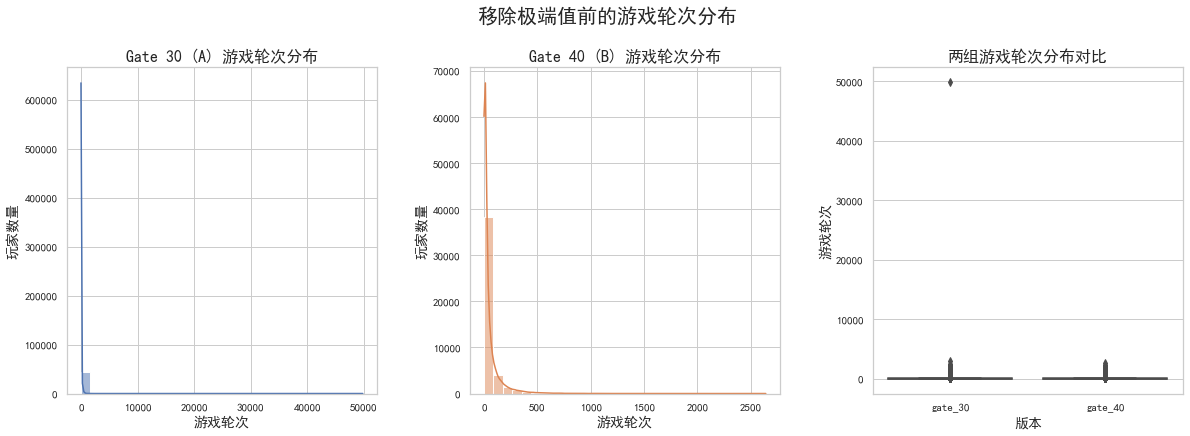

In [53]:
# 设置Seaborn的主题风格
sns.set(style="whitegrid")

# 配置中文字体
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 使用黑体
plt.rcParams["axes.unicode_minus"] = False    # 解决负号无法正常显示的问题

# 创建一个包含1行3列的子图布局，图形大小调整为宽度20英寸，高度6英寸
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 绘制Gate 30的直方图
sns.histplot(
    ab_test_data[ab_test_data["version"] == "gate_30"]["sum_gamerounds"],
    bins=30,  # 设置柱子的数量
    color="#4C72B0",  # 使用Seaborn的默认蓝色
    kde=True,  # 添加核密度估计曲线
    ax=axes[0]
)
axes[0].set_title("Gate 30 (A) 游戏轮次分布", fontsize=16)
axes[0].set_xlabel("游戏轮次", fontsize=14)
axes[0].set_ylabel("玩家数量", fontsize=14)

# 绘制Gate 40的直方图
sns.histplot(
    ab_test_data[ab_test_data["version"] == "gate_40"]["sum_gamerounds"],
    bins=30,
    color="#DD8452",  # 使用Seaborn的默认橙色
    kde=True,
    ax=axes[1]
)
axes[1].set_title("Gate 40 (B) 游戏轮次分布", fontsize=16)
axes[1].set_xlabel("游戏轮次", fontsize=14)
axes[1].set_ylabel("玩家数量", fontsize=14)

# 绘制箱线图，统一使用Seaborn的风格
sns.boxplot(
    x="version",
    y="sum_gamerounds",
    data=ab_test_data,
    palette=["#4C72B0", "#DD8452"],  # 设置箱线图的颜色
    ax=axes[2]
)
axes[2].set_title("两组游戏轮次分布对比", fontsize=16)
axes[2].set_xlabel("版本", fontsize=14)
axes[2].set_ylabel("游戏轮次", fontsize=14)

# 设置整个图形的标题，并调整字体大小
fig.suptitle("移除极端值前的游戏轮次分布", fontsize=20, y=1.02)  # 调整y位置避免标题与子图重叠

# 调整子图之间的水平和垂直间距
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# 显示图形
plt.show()

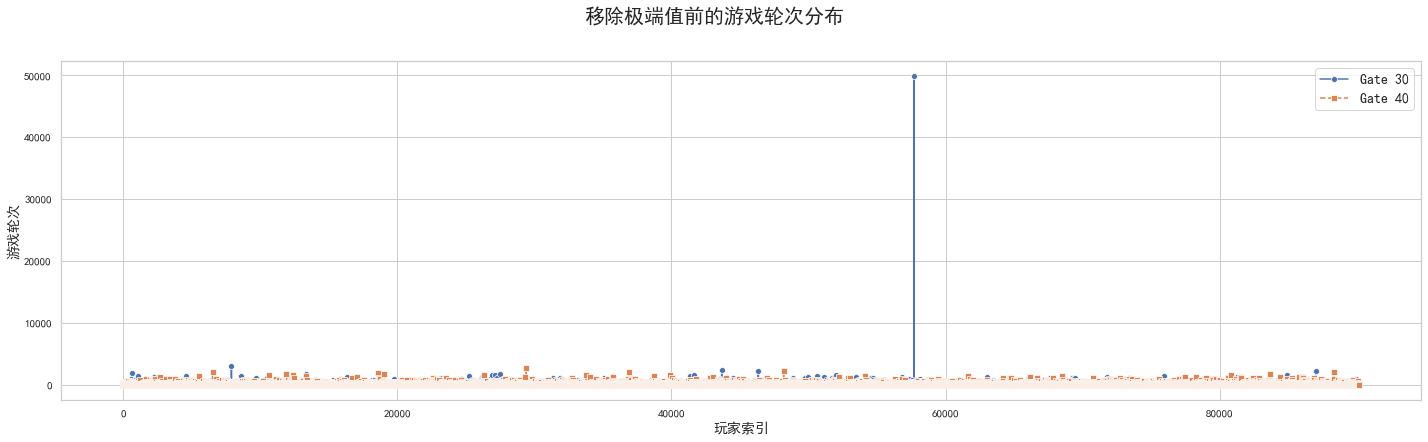

In [54]:
# 设置Seaborn的主题风格
sns.set(style="whitegrid")

plt.rcParams["font.sans-serif"] = ["SimHei"]  # 使用黑体

# 创建一个图形对象
plt.figure(figsize=(20, 6))

# 绘制Gate 30的游戏轮次分布图
sns.lineplot(
    x=ab_test_data[ab_test_data["version"] == "gate_30"].index,  # 使用原始索引作为x轴
    y=ab_test_data[ab_test_data["version"] == "gate_30"]["sum_gamerounds"],  # y轴为sum_gamerounds
    label="Gate 30",  # 图例标签
    color="#4C72B0",  # 蓝色
    marker="o",  # 添加圆点标记
    linestyle="-"  # 实线
)

# 绘制Gate 40的游戏轮次分布图
sns.lineplot(
    x=ab_test_data[ab_test_data["version"] == "gate_40"].index,  # 使用原始索引作为x轴
    y=ab_test_data[ab_test_data["version"] == "gate_40"]["sum_gamerounds"],  # y轴为sum_gamerounds
    label="Gate 40",  # 图例标签
    color="#DD8452",  # 橙色
    marker="s",  # 方形标记
    linestyle="--"  # 虚线
)

# 设置整个图形的标题
plt.suptitle("移除极端值前的游戏轮次分布", fontsize=20, y=1.02)  # 调整y位置避免标题与图表重叠

# 设置x轴和y轴标签
plt.xlabel("玩家索引", fontsize=14)
plt.ylabel("游戏轮次", fontsize=14)

# 添加图例
plt.legend(fontsize=14)

# 调整子图间距
plt.tight_layout()

# 显示图形
plt.show()

# Outliers

| 方法            | 特点                                                                 | 适用场景                          |
|-----------------|----------------------------------------------------------------------|-----------------------------------|
| IQR方法         | 自动适应数据分布，过滤上下各约2.5%的数据                              | 大多数统计分析                    |
| Z-score方法     | 基于均值和标准差，适合正态分布数据                                    | 对称分布的数据清洗                |
| 业务规则过滤    | 根据实际业务定义阈值（如游戏时长>1000分钟为异常）                      | 有明确业务逻辑的场景              |

In [55]:
ab_test_data.groupby("sum_gamerounds").userid.count().reset_index().tail(10)

,sum_gamerounds,userid
932,2015,1
933,2063,1
934,2124,1
935,2156,1
936,2251,1
937,2294,1
938,2438,1
939,2640,1
940,2961,1
941,49854,1


In [56]:
# 方法1：基于IQR的异常值过滤（保留95%数据）
#Q1 = ab_test_data.sum_gamerounds.quantile(0.25)
#Q3 = ab_test_data.sum_gamerounds.quantile(0.75)
#IQR = Q3 - Q1
#lower = Q1 - 1.5 * IQR
#upper = Q3 + 1.5 * IQR
#ab = ab_test_data[(ab_test_data.sum_gamerounds >= lower) & (ab_test_data.sum_gamerounds <= upper)]

# 方法2：基于Z-score的异常值过滤（默认阈值±3σ）
#from scipy import stats
#z_scores = np.abs(stats.zscore(ab.sum_gamerounds))
#ab = ab[z_scores < 3]

# 方法3：基于业务规则的异常值过滤（例如游戏轮次超过1000为异常）
ab = ab_test_data[ab_test_data.sum_gamerounds < 3000]

In [57]:
ab.shape

(90188, 5)

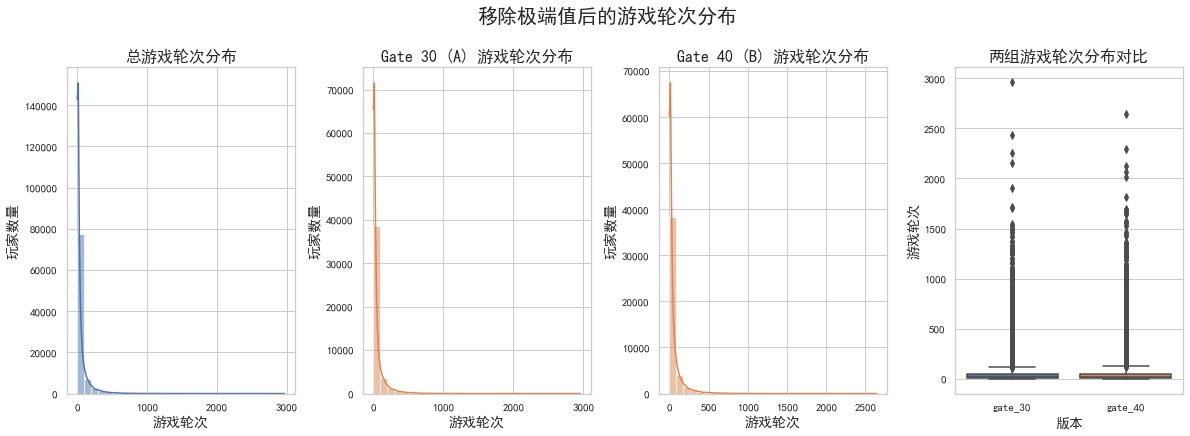

In [58]:
# 设置Seaborn的主题风格
sns.set(style="whitegrid")

plt.rcParams["font.sans-serif"] = ["SimHei"]  # 使用黑体

# 创建一个包含1行4列的子图布局，图形大小调整为宽度20英寸，高度6英寸
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# 绘制总游戏轮次的直方图
sns.histplot(
    ab.sum_gamerounds,
    bins=30,
    color="#4C72B0",
    kde=True,
    ax=axes[0]
)
axes[0].set_title("总游戏轮次分布", fontsize=16)
axes[0].set_xlabel("游戏轮次", fontsize=14)
axes[0].set_ylabel("玩家数量", fontsize=14)

# 绘制Gate 30的直方图
sns.histplot(
    ab[ab["version"] == "gate_30"]["sum_gamerounds"],
    bins=30,
    color="#DD8452",
    kde=True,
    ax=axes[1]
)
axes[1].set_title("Gate 30 (A) 游戏轮次分布", fontsize=16)
axes[1].set_xlabel("游戏轮次", fontsize=14)
axes[1].set_ylabel("玩家数量", fontsize=14)

# 绘制Gate 40的直方图
sns.histplot(
    ab[ab["version"] == "gate_40"]["sum_gamerounds"],
    bins=30,
    color="#DD8452",
    kde=True,
    ax=axes[2]
)
axes[2].set_title("Gate 40 (B) 游戏轮次分布", fontsize=16)
axes[2].set_xlabel("游戏轮次", fontsize=14)
axes[2].set_ylabel("玩家数量", fontsize=14)

# 绘制箱线图
sns.boxplot(
    x="version",
    y="sum_gamerounds",
    data=ab,
    palette=["#4C72B0", "#DD8452"],
    ax=axes[3]
)
axes[3].set_title("两组游戏轮次分布对比", fontsize=16)
axes[3].set_xlabel("版本", fontsize=14)
axes[3].set_ylabel("游戏轮次", fontsize=14)

# 设置整个图形的标题
fig.suptitle("移除极端值后的游戏轮次分布", fontsize=20, y=1.02)  # 调整y位置避免标题与子图重叠

# 调整子图之间的水平和垂直间距
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# 显示图形
plt.show()

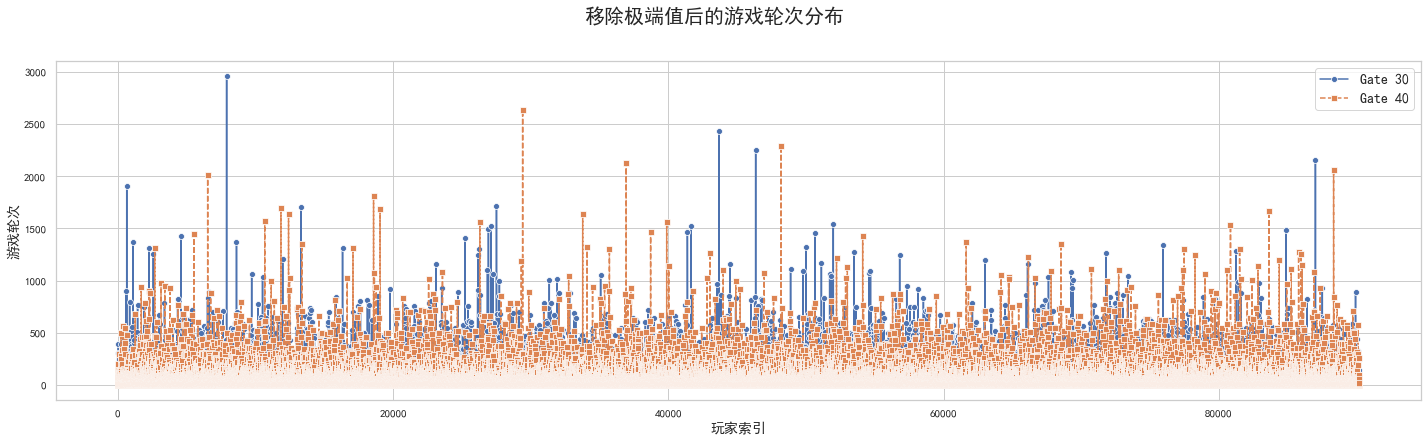

In [59]:
# 设置Seaborn的主题风格
sns.set(style="whitegrid")

plt.rcParams["font.sans-serif"] = ["SimHei"]  # 使用黑体

# 创建一个图形对象
plt.figure(figsize=(20, 6))

# 绘制Gate 30的游戏轮次分布图
sns.lineplot(
    x=ab[ab["version"] == "gate_30"].index,  # 使用原始索引作为x轴
    y=ab[ab["version"] == "gate_30"]["sum_gamerounds"],  # y轴为sum_gamerounds
    label="Gate 30",  # 图例标签
    color="#4C72B0",  # 蓝色
    marker="o",  # 添加圆点标记
    linestyle="-"  # 实线
)

# 绘制Gate 40的游戏轮次分布图
sns.lineplot(
    x=ab[ab["version"] == "gate_40"].index,  # 使用原始索引作为x轴
    y=ab[ab["version"] == "gate_40"]["sum_gamerounds"],  # y轴为sum_gamerounds
    label="Gate 40",  # 图例标签
    color="#DD8452",  # 橙色
    marker="s",  # 方形标记
    linestyle="--"  # 虚线
)

# 设置整个图形的标题
plt.suptitle("移除极端值后的游戏轮次分布", fontsize=20, y=1.02)  # 调整y位置避免标题与图表重叠

# 设置x轴和y轴标签
plt.xlabel("玩家索引", fontsize=14)
plt.ylabel("游戏轮次", fontsize=14)

# 添加图例
plt.legend(fontsize=14)

# 调整子图间距
plt.tight_layout()

# 显示图形
plt.show()

# Details

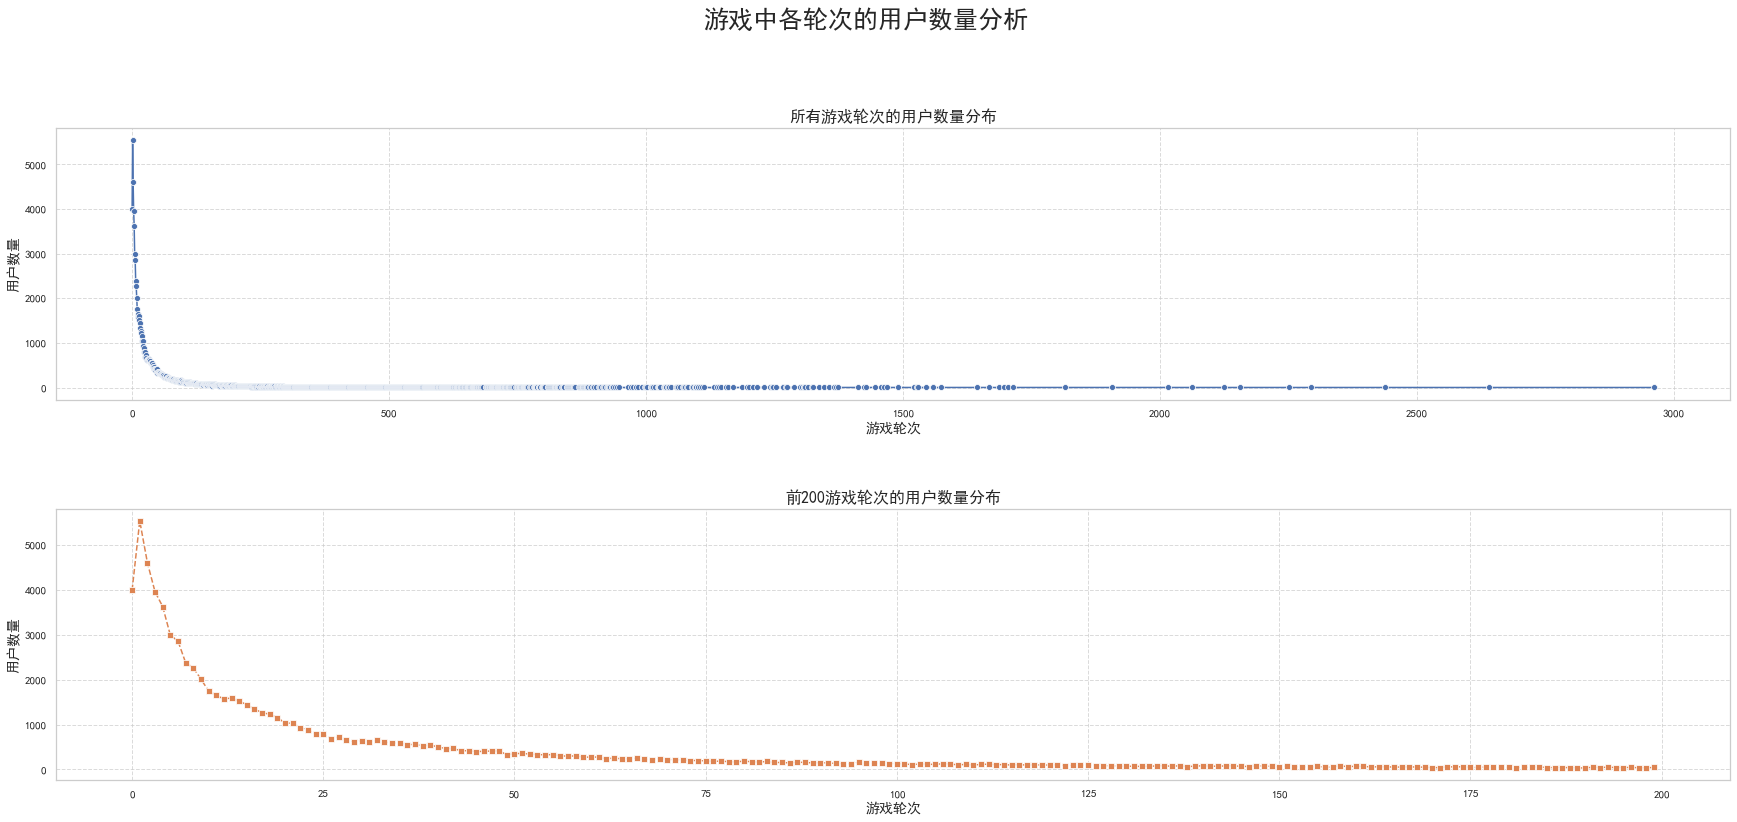

In [60]:
# 设置Seaborn的主题风格
sns.set(style="whitegrid")

plt.rcParams["font.sans-serif"] = ["SimHei"]  # 使用黑体

# 创建一个包含2行1列的子图布局，图形大小调整为宽度30英寸，高度12英寸
fig, axes = plt.subplots(2, 1, figsize=(30, 12))

# 绘制所有轮次的用户数量分布
sns.lineplot(
    x=ab.groupby("sum_gamerounds").size().index,  
    y=ab.groupby("sum_gamerounds").size().values,  
    ax=axes[0],
    color="#4C72B0",  
    marker="o",  
    linestyle="-" 
)
axes[0].set_title("所有游戏轮次的用户数量分布", fontsize=16)
axes[0].set_xlabel("游戏轮次", fontsize=14)
axes[0].set_ylabel("用户数量", fontsize=14)
axes[0].grid(True, linestyle="--", alpha=0.7)  # 添加网格线

# 绘制前200轮的用户数量分布
sns.lineplot(
    x=ab.groupby("sum_gamerounds").size().index[:200],  
    y=ab.groupby("sum_gamerounds").size().values[:200],  
    ax=axes[1],
    color="#DD8452",  
    marker="s",  
    linestyle="--"  
)
axes[1].set_title("前200游戏轮次的用户数量分布", fontsize=16)
axes[1].set_xlabel("游戏轮次", fontsize=14)
axes[1].set_ylabel("用户数量", fontsize=14)
axes[1].grid(True, linestyle="--", alpha=0.7)  # 添加网格线

# 设置整个图形的标题
fig.suptitle("游戏中各轮次的用户数量分析", fontsize=25, y=1.02) 

# 调整子图之间的垂直间距
plt.subplots_adjust(hspace=0.4)

# 显示图形
plt.show()

In [61]:
ab.groupby("sum_gamerounds").userid.count().reset_index().head(20)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


In [62]:
ab.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

In [63]:
ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0000,51.3421,102.0576,2961
gate_40,45489,16.0000,51.2988,103.2944,2640


## 留存率
- ​retention_1 - 玩家在安装游戏后1天是否回来继续游玩？
- ​retention_7 - 玩家在安装游戏后7天是否回来继续游玩？

In [64]:
pd.DataFrame({"RET1_COUNT": ab["retention_1"].value_counts(),
              "RET7_COUNT": ab["retention_7"].value_counts(),
              "RET1_RATIO": ab["retention_1"].value_counts() / len(ab),
              "RET7_RATIO": ab["retention_7"].value_counts() / len(ab)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.5548,0.8139
True,40153,16780,0.4452,0.1861


In [65]:
ab.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median    mean      std   max
version retention_1                                      
gate_30 False        24665  6.0000 16.3591  36.5284  1072
        True         20034 48.0000 94.4117 135.0377  2961
gate_40 False        25370  6.0000 16.3404  35.9258  1241
        True         20119 49.0000 95.3812 137.8873  2640

In [66]:
ab.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count   median     mean      std   max
version retention_7                                        
gate_30 False        36198  11.0000  25.7965  43.3162   981
        True          8501 105.0000 160.1175 179.3586  2961
gate_40 False        37210  11.0000  25.8564  44.4061  2640
        True          8279 111.0000 165.6498 183.7925  2294

In [67]:
#第一天和第七天均留存的定义为留存用户
ab["Retention"] = np.where((ab.retention_1 == True) & (ab.retention_7 == True), 1,0)
# 统计各版本的留存用户数量
ab.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count   median     mean      std   max
version Retention                                        
gate_30 0          38023  12.0000  28.0703  48.0175  1072
        1           6676 127.0000 183.8863 189.6264  2961
gate_40 0          38983  12.0000  28.1034  48.9278  2640
        1           6506 133.0000 190.2824 194.2201  2294

In [68]:
ab["NewRetention"] = list(map(lambda x,y: str(x)+"-"+str(y), ab.retention_1, ab.retention_7))
ab.groupby(["version", "NewRetention"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

,version,NewRetention,count,median,mean,std,max
0,gate_30,False-False,22840,6.0000,11.8197,21.6426,981
1,gate_30,False-True,1825,43.0000,73.1693,93.2223,1072
2,gate_30,True-False,13358,33.0000,49.6945,58.1254,918
3,gate_30,True-True,6676,127.0000,183.8863,189.6264,2961
4,gate_40,False-False,23597,6.0000,11.9133,20.9010,547
5,gate_40,False-True,1773,47.0000,75.2611,94.4780,1241
6,gate_40,True-False,13613,32.0000,50.0255,60.9246,2640
7,gate_40,True-True,6506,133.0000,190.2824,194.2201,2294


# A/B Testing

**假设：**

- 检查数据是否服从正态分布
- 若数据服从正态分布，则检查方差是否齐性（检查不同组间方差是否一致）

**​步骤：**

1.​分组并定义对照组与实验组

2.​应用夏皮罗-威尔克检验（Shapiro-Wilk Test）检验正态性

3.​若为参数检验：
  - 应用莱文检验（Levene Test）检验方差齐性
  - ​若方差齐性成立：使用 t 检验（T-Test）
  - ​若方差非齐性：使用魏尔奇检验（Welch Test）
  
4.​若为非参数检验：直接应用曼-惠特尼 U 检验（Mann-Whitney U Test）

In [69]:
ab["version"] = np.where(ab.version == "gate_30", "A", "B")
ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,NewRetention
0,116,A,3,False,False,0,False-False
1,337,A,38,True,False,0,True-False
2,377,B,165,True,False,0,True-False
3,483,B,1,False,False,0,False-False
4,488,B,179,True,True,1,True-True


In [72]:
def AB_Test(dataframe, group, target, alternative='two-sided'):
    """
    A/B测试函数，支持单侧检验和双侧检验。
    
    参数：
    - dataframe: 数据框
    - group: 分组列名（如"version"）
    - target: 目标指标列名（如"sum_gamerounds"）
    - alternative: 检验类型，'two-sided'（双侧）、'less'（单侧-小于）、'greater'（单侧-大于）
    """
    from scipy.stats import shapiro
    import scipy.stats as stats
    import numpy as np
    import pandas as pd

    # 按照分组列将数据分为A组和B组
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]

    # 正态性检验
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05

    # 如果两组数据均服从正态分布
    if not ntA and not ntB:
        # 方差齐性检验
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05

        if not leveneTest:
            # 方差齐性，使用独立t检验
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True, alternative=alternative)[1]
        else:
            # 方差不齐，使用Welch校正t检验
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False, alternative=alternative)[1]
    else:
        # 非参数检验（曼-惠特尼U检验）
        ttest = stats.mannwhitneyu(groupA, groupB, alternative=alternative)[1]

    # 构建结果数据框
    temp = pd.DataFrame({
        "AB假设": [ttest < 0.05],
        "p值": [ttest]
    })
    temp["检验类型"] = "参数检验" if not ntA and not ntB else "非参数检验"
    temp["AB假设"] = np.where(temp["AB假设"] == False, "无法拒绝H0", "拒绝H0")
    temp["结论"] = np.where(temp["AB假设"] == "拒绝H0", "A/B组存在显著差异！", "A/B组无显著差异！")

    if not ntA and not ntB:
        temp["方差齐性"] = np.where(leveneTest == False, "是", "否")
        temp = temp[["检验类型", "方差齐性", "AB假设", "p值", "结论"]]
    else:
        temp = temp[["检验类型", "AB假设", "p值", "结论"]]

    # 打印假设
    print("# A/B测试假设")
    print("H0: A == B")
    print("H1: 根据选择的检验类型（单侧或双侧）", "\n")

    return temp


In [74]:
# 双侧检验
AB_Test(dataframe=ab, group="version", target="sum_gamerounds", alternative='two-sided')

# A/B测试假设
H0: A == B
H1: 根据选择的检验类型（单侧或双侧） 



,检验类型,AB假设,p值,结论
0,非参数检验,无法拒绝H0,0.0509,A/B组无显著差异！


In [75]:
# 单侧检验（A组均值是否显著小于B组）
AB_Test(dataframe=ab, group="version", target="sum_gamerounds", alternative='less')

# A/B测试假设
H0: A == B
H1: 根据选择的检验类型（单侧或双侧） 



,检验类型,AB假设,p值,结论
0,非参数检验,无法拒绝H0,0.9746,A/B组无显著差异！


In [76]:
# 单侧检验（A组均值是否显著大于B组）
AB_Test(dataframe=ab, group="version", target="sum_gamerounds", alternative='greater')

# A/B测试假设
H0: A == B
H1: 根据选择的检验类型（单侧或双侧） 



,检验类型,AB假设,p值,结论
0,非参数检验,拒绝H0,0.0254,A/B组存在显著差异！
